<a href="https://colab.research.google.com/github/AashiDutt/AI-and-ML-for-Coders/blob/main/Chapter_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab contains code for:

1. Using convolutions for sequence data

2. Working with NASA Weather data (GISS surface temperature analysis)

In [2]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [3]:
# Imports

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


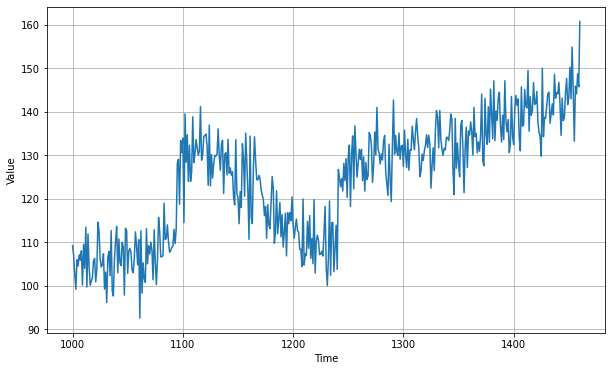

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [6]:
# Creating windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 24 Complete [00h 01m 25s]
loss: 61.81985092163086

Best loss So Far: 59.91740290323893
Total elapsed time: 00h 39m 06s
INFO:tensorflow:Oracle triggered exit


Applying optimum results found from previous code

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, 
                            shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=9,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, input_shape=[window_size], 
                           activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)



Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 5ms/step - loss: 585.9074
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 108.8365
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 85.5486
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 77.7024
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 71.8139
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 68.9212
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 69.1413
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 66.1266
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 67.5498
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 64.9251
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 65.9184
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 67.0972
Epoch 13/100
31/31 [===============

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

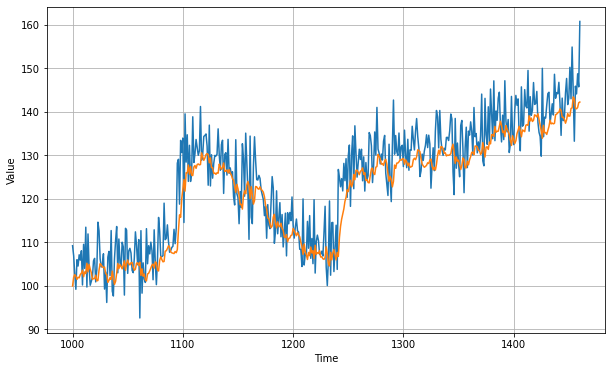

In [18]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0516014

Working with NASA Weather data (GISS surface temperature analysis)